# Generación de un modelo para clasificacion de flores
---
**Configuración General del Entorno de Trabajo**

Esta sección detecta si el notebook está corriendo en un entorno COLAB o en uno LOCAL . Monta la carpeta de Google Drive si corresponde y define constantes para trabajar de forma general con cualquir script. Modificar las definiciones de las carpetas según el entorno y configuración del mismo.

In [ ]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = './DATOS/'  # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../DATOS/' # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


---
### Preparación de Dataset

Para poder trabajar con el dataset se debe:
1. Copiar el archivo FlowersX16.zip en la carpeta drive de los datos (establecida para este script en DATOS_DIR).
2. Ubicar el directorio actual en la misma carpeta
3. Descomprimir con Zip el archivo

In [ ]:
import zipfile
import os
#import gdown

# Ruta al archivo ZIP en Google Drive
zip_path = os.path.join(DATOS_DIR, 'FlowersX16.zip')

# Ruta de destino para la extracción (carpeta local)
extract_dir = LOCAL_DIR

# Verificar si el archivo ZIP existe
if not os.path.exists(zip_path):
    print(f"Error: El archivo {zip_path} no existe.")
else:
    # Crear la carpeta de destino si no existe
    os.makedirs(extract_dir, exist_ok=True)

    # Descomprimir el archivo ZIP
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Archivo descomprimido exitosamente en: {extract_dir}")
    except zipfile.BadZipFile:
        print("Error: El archivo ZIP está corrupto o no es válido.")
    except Exception as e:
        print(f"Ocurrió un error al descomprimir: {str(e)}")

Archivo descomprimido exitosamente en: ./DATOS/


**Preparación de Datos**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from tf_util import EpochTiming
import tensorflow as tf

# Constantes para arquitectura, generación de datos y entrenamiento/validación
IMG_SIZE = (96, 96)  # Tamaño de la imagen de entrada (se elimina el canal de la tupla)
N_CLASSES = 16       # Cantidad de clases a identificar
LOTES = 256          # Tamaño de lotes para entrenamiento y testeo
ALFA = 0.0005        # Tasa de aprendizaje
EPOCAS = 100         # Cantidad de épocas a entrenar como máximo
PACIENCIA = 10       # Parámetro para parada temprana
VAL_SPLIT = 0.2      # Porcentaje para validación

IMAGES_DIR = LOCAL_DIR + 'FlowersX16/'

# Función para crear datasets con aumento de datos
def create_dataset(directory, subset=None, shuffle=True):
    # Cargar dataset desde directorio
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=VAL_SPLIT,
        subset=subset,
        seed=123,
        image_size=IMG_SIZE,
        batch_size=LOTES,
        shuffle=shuffle
    )

    # Normalización
    def preprocess(image, label):
        return image/255.0, label

    # Aumento de datos (solo para entrenamiento)
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)

        # Zoom y desplazamiento
        if tf.random.uniform(()) > 0.5:
            image = tf.image.central_crop(image, 0.85)
            image = tf.image.resize(image, IMG_SIZE)

        return image, label

    dataset = dataset.map(preprocess)
    if subset == 'training':
        dataset = dataset.map(augment) # Esto se puede aplicar a cualquier cosa, no solo a imágenes. ¿Ejemplos? Aumento de datos en texto, como sinónimos o parafraseo.

    return dataset.cache().prefetch(tf.data.AUTOTUNE)

# Crear datasets
train_ds = create_dataset(IMAGES_DIR, subset='training', shuffle=True)
valid_ds = create_dataset(IMAGES_DIR, subset='validation', shuffle=False)

Found 15740 files belonging to 16 classes.
Using 12592 files for training.
Found 15740 files belonging to 16 classes.
Using 3148 files for validation.


**Construcción del Modelo**

In [ ]:
ACTIVATION = 'relu'
PADDING = 'same'

model = Sequential()

model.add(Input(shape=(*IMG_SIZE, 3)))
model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation=ACTIVATION, padding=PADDING))
# model.add(BatchNormalization())    # Agregada después de la primera capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN

model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
#model.add(BatchNormalization())  # Agregada después de la segunda capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())  # Agregada después de la tercera capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())  # Agregada después de la cuarta capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())  # Agregada después de la quinta capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())  # Agregada después de la sexta capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())  # Agregada después de la séptima capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())  # Agregada después de la octava capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())  # Agregada después de la octava capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN

model.add(Dense(N_CLASSES, activation = 'softmax'))

model.summary()

# obtiene la arquitectura para el modelo y lo compila
optimizer = optimizers.Adam(ALFA)
model.compile(optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 96, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 96, 96, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 315,168 (1.20 MB)

 Trainable params: 314,016 (1.20 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
# Callback para parada temprana
early_stop = EarlyStopping(monitor='val_loss',
                           patience=PACIENCIA,
                           restore_best_weights=True)

epoch_timing = EpochTiming()

H = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCAS,
    callbacks=[early_stop, epoch_timing])

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 345ms/step - accuracy: 0.2217 - loss: 2.5002 - val_accuracy: 0.0000e+00 - val_loss: 2.7714
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.4628 - loss: 1.6282 - val_accuracy: 0.0000e+00 - val_loss: 2.9001
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.5665 - loss: 1.3270 - val_accuracy: 0.0000e+00 - val_loss: 3.0983
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.6348 - loss: 1.1174 - val_accuracy: 0.0000e+00 - val_loss: 3.3154
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.6899 - loss: 0.9627 - val_accuracy: 0.0000e+00 - val_loss: 3.5080
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7266 - loss: 0.8538 - val_accuracy: 0.0000e+00 - val_loss: 3.6852
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.7741 - loss: 0.7292 - val_accuracy: 0.0000e+00 - val_loss: 3.8529
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.8020 -

### Evaluación el Modelo

Tiempo promedio por época 5.92 segundos
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9328 - loss: 0.2146
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8440 - loss: 0.6104


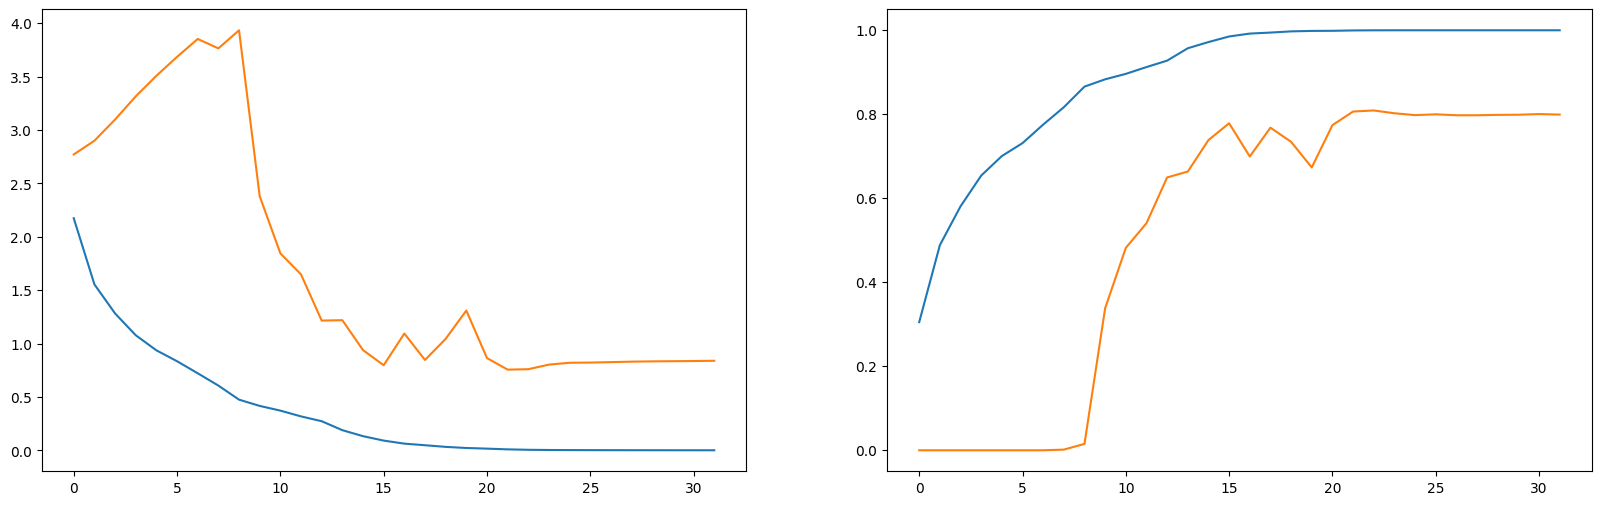

<Figure size 640x480 with 0 Axes>

In [ ]:
print('Tiempo promedio por época %.2f segundos' % epoch_timing.avg_epoch_time)
model.evaluate(train_ds)
model.evaluate(valid_ds)

# dibuja accuracy del progreso del entrenamiento
fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")

In [ ]:
model.save(DATOS_DIR+'flowers_colab_Ejer_05_b.keras')